### Импорт библиотек

In [2]:
import numpy as np
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import statsmodels.api as sm
from datetime import datetime
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

### Загрузка данных временного ряда с ценами активов Apple

In [3]:
# Загрузка данных о компании Apple с Yahoo Finance
apple = yf.Ticker("AAPL")
# Получение исторических данных за последний год
df = apple.history(period="1y")
df = df.drop(columns=["Dividends", "Stock Splits"])  # Удаление ненужных столбцов
df.index = pd.to_datetime(df.index)  # Убедиться, что индекс в формате даты
print(df)

                                 Open        High         Low       Close  \
Date                                                                        
2023-12-26 00:00:00-05:00  192.666124  192.944757  191.889928  192.108856   
2023-12-27 00:00:00-05:00  191.551588  192.556659  190.158404  192.208359   
2023-12-28 00:00:00-05:00  193.193528  193.710998  192.228256  192.636261   
2023-12-29 00:00:00-05:00  192.954701  193.452263  190.795282  191.591385   
2024-01-02 00:00:00-05:00  186.237618  187.521338  182.993517  184.734985   
...                               ...         ...         ...         ...   
2024-12-17 00:00:00-05:00  250.080002  253.830002  249.779999  253.479996   
2024-12-18 00:00:00-05:00  252.160004  254.279999  247.740005  248.050003   
2024-12-19 00:00:00-05:00  247.500000  252.000000  247.089996  249.789993   
2024-12-20 00:00:00-05:00  248.039993  255.000000  245.690002  254.490005   
2024-12-23 00:00:00-05:00  254.770004  255.645004  253.449997  254.815002   

### Визуалиация временного ряда

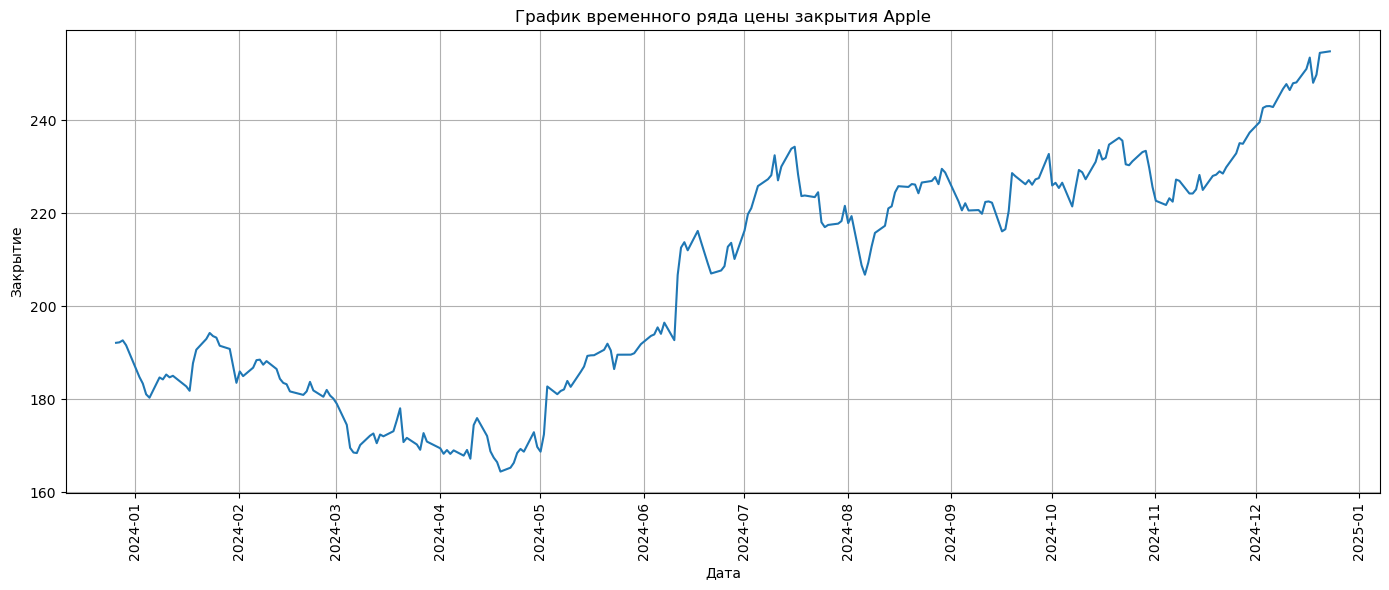

In [6]:
plt.figure(figsize=(14, 6))
plt.plot(df.index, df["Close"])  # Используем столбец 'Close' из данных yfinance
plt.gca().xaxis.set_major_locator(mdates.MonthLocator()) 
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().set_xlim(df.index[0] - pd.Timedelta(days=15), df.index[-1] + pd.Timedelta(days=15))
plt.xlabel("Дата")
plt.ylabel("Закрытие")
plt.title("График временного ряда цены закрытия Apple")
plt.gcf().autofmt_xdate()
plt.xticks(rotation=90, ha="center")
plt.tight_layout()
plt.grid()
plt.show()

### Декомпозиция временного ряда

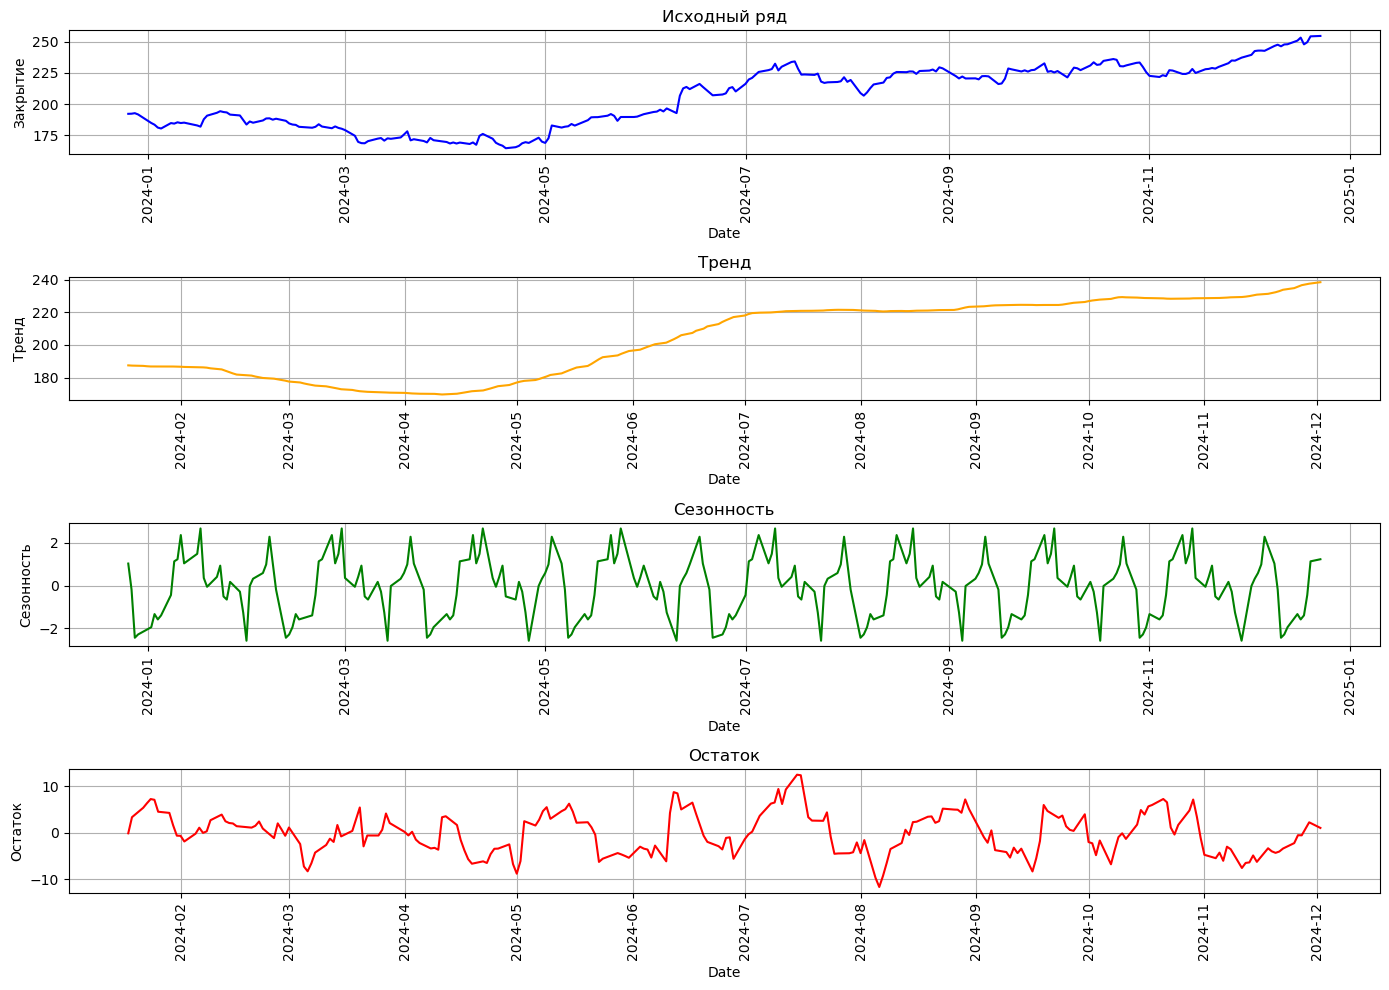

In [11]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Указываем меньший период, например, для месячной сезонности
decomposition = seasonal_decompose(df['Close'], model='additive', period=30)

# Создание субграфиков
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(14, 10))

# Исходный ряд
decomposition.observed.plot(ax=ax1, color='blue')
ax1.set_title('Исходный ряд')
ax1.set_ylabel("Закрытие")

# Тренд
decomposition.trend.plot(ax=ax2, color='orange')
ax2.set_title('Тренд')
ax2.set_ylabel("Тренд")

# Сезонность
decomposition.seasonal.plot(ax=ax3, color='green')
ax3.set_title('Сезонность')
ax3.set_ylabel("Сезонность")

# Остаток
decomposition.resid.plot(ax=ax4, color='red')
ax4.set_title('Остаток')
ax4.set_ylabel("Остаток")

# Настройка подписей
for ax in [ax1, ax2, ax3, ax4]:
    plt.setp(ax.get_xticklabels(), rotation=90, ha='center')
    ax.grid()

plt.tight_layout()
plt.show()


### Сравнение исходного ряда с десезонализированным

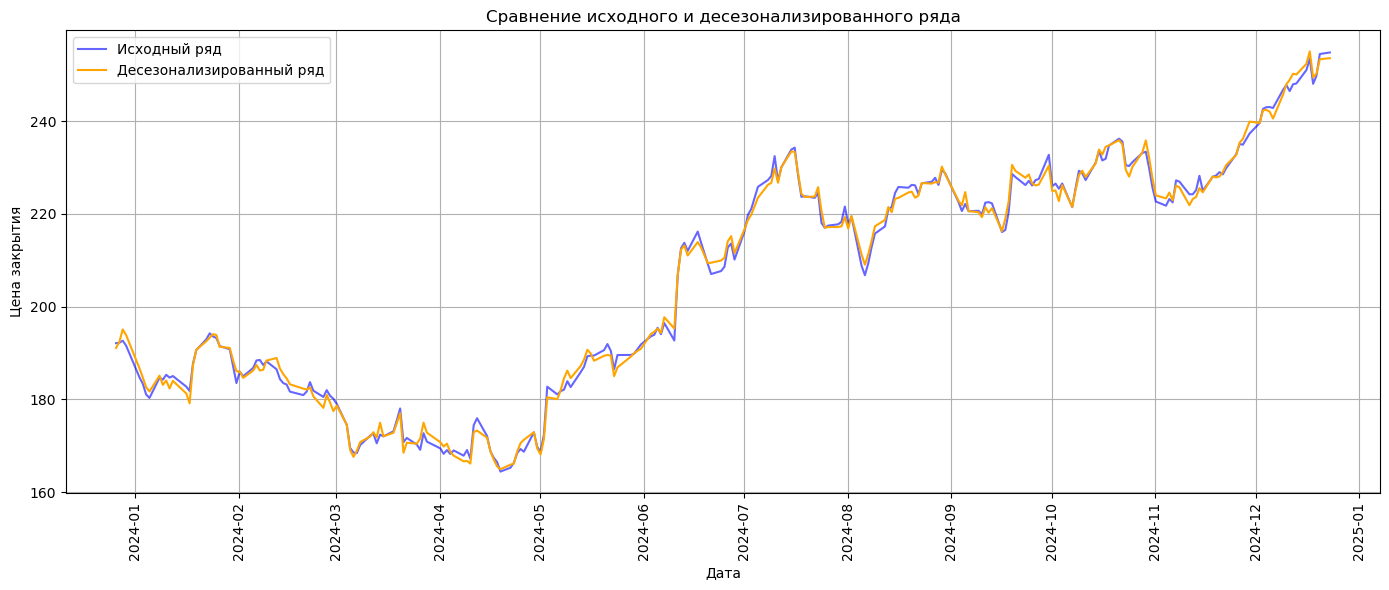

In [13]:
# Сравнение исходного ряда с десезонализированным
seasonal = decomposition.seasonal.dropna()
deseasonalized = decomposition.observed - seasonal

plt.figure(figsize=(14, 6))
plt.plot(df.index, df["Close"], label='Исходный ряд', alpha=0.6, color='blue')  # Используем 'Close' из данных
plt.plot(deseasonalized.index, deseasonalized, label='Десезонализированный ряд', color='orange')
plt.legend()
plt.title('Сравнение исходного и десезонализированного ряда')
plt.xlabel('Дата')
plt.ylabel('Цена закрытия')
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().set_xlim(df.index[0] - pd.Timedelta(days=15), df.index[-1] + pd.Timedelta(days=15))
plt.xticks(rotation=90, ha='center')
plt.tight_layout()
plt.grid()
plt.show()



### Прогноз на основе выявленных тренда и сезонности

C:\Users\idont\AppData\Local\Temp\ipykernel_3988\1520166434.py:14: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = df['Close'].resample('D').last().fillna(method='ffill')
D:\ANACONDA\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


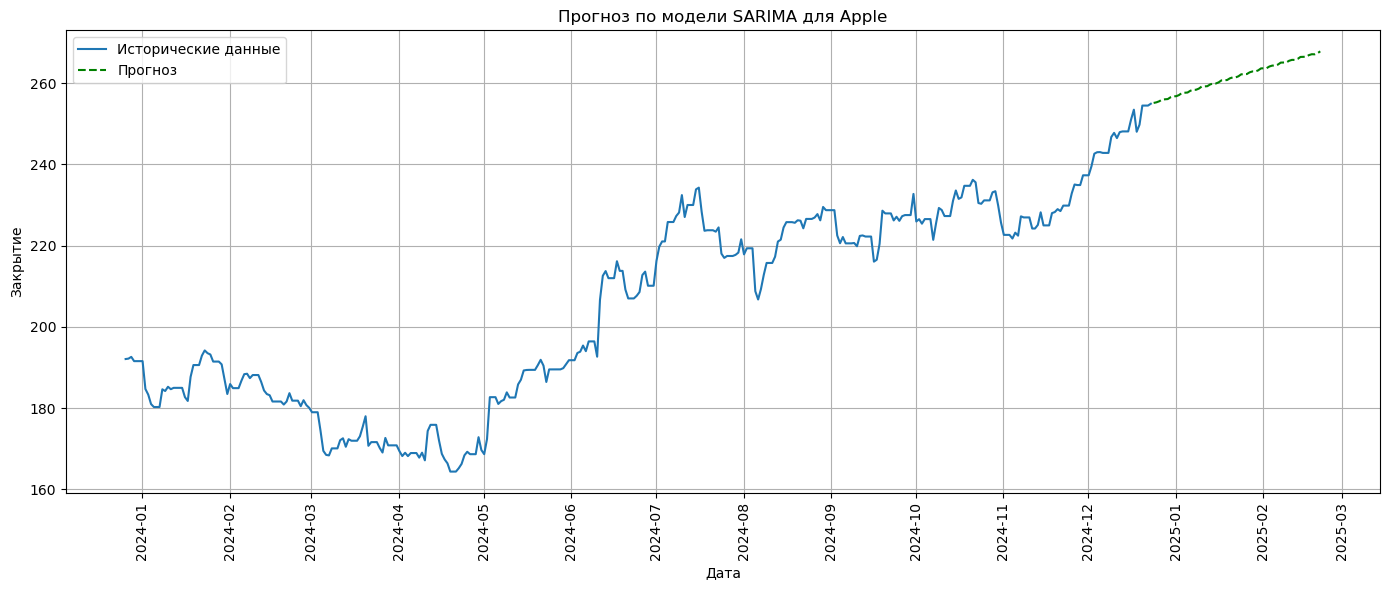

In [33]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Загрузка данных
apple = yf.Ticker("AAPL")
df = apple.history(period="1y")
df = df.drop(columns=["Dividends", "Stock Splits"])  # Удаление ненужных столбцов
df.index = pd.to_datetime(df.index)  # Убедиться, что индекс в формате даты

# Данные для анализа
data = df['Close'].resample('D').last().fillna(method='ffill')

# Определим параметры модели SARIMA. Параметры (p,d,q) и (P,D,Q,s) нужно подбирать.
# p=1, d=1, q=1 - это параметры ARIMA, а P=1, D=1, Q=1, s=7 - это параметры сезонности для еженедельного цикла.
model = SARIMAX(data, order=(1,1,1), seasonal_order=(1,1,1,7))

# Обучаем модель
results = model.fit()

# Прогноз на 60 дней вперед
forecast = results.get_forecast(steps=60)
forecast_mean = forecast.predicted_mean

# Визуализация
plt.figure(figsize=(14, 6))
plt.plot(data.index, data.values, label='Исторические данные')
plt.plot(forecast_mean.index, forecast_mean.values, label='Прогноз', color='green', linestyle='--')
plt.gca().xaxis.set_major_locator(mdates.MonthLocator()) 
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xlabel("Дата")
plt.ylabel("Закрытие")
plt.title("Прогноз по модели SARIMA для Apple")
plt.legend()
plt.gcf().autofmt_xdate()
plt.xticks(rotation=90, ha="center")
plt.tight_layout()
plt.grid()
plt.show()

### Оценка качества прогноза, используя метрики MAE и RMSE

In [36]:
forecast_days = 60  # Количество дней прогноза

# Получаем последние forecast_days значений из оригинального датафрейма
true_values = df["Close"].iloc[-forecast_days:]  # Используем 'Close' вместо '<CLOSE>'

# Получаем прогнозные значения из future_df_deseasonalized
forecast_values = future_df_deseasonalized.values

# Рассчитываем MAE и RMSE
mae = mean_absolute_error(true_values, forecast_values)
rmse = np.sqrt(mean_squared_error(true_values, forecast_values))

print(f"MAE: {mae}")
print(f"RMSE: {rmse}")

MAE: 9.015646016883663
RMSE: 9.96513908617186


### Тест на стационарность

In [39]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series):
    # Проведение теста Дики-Фуллера
    result = adfuller(series, autolag='AIC')
    print('Результаты теста Дики-Фуллера:')
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print('Критические значения:')
    for key, value in result[4].items():
        print(f'\t{key}: {value}')

# Предполагается, что deseasonalized - это ваш временной ряд после удаления сезонности
adf_test(deseasonalized)

Результаты теста Дики-Фуллера:
ADF Statistic: 0.1126802000379672
p-value: 0.9669162425125535
Критические значения:
	1%: -3.456780859712
	5%: -2.8731715065600003
	10%: -2.572968544


В результате теста получено значение p-value: 0.96 > 0.05, значит временной ряд считается нестационарным.

### Приведение к стационарности

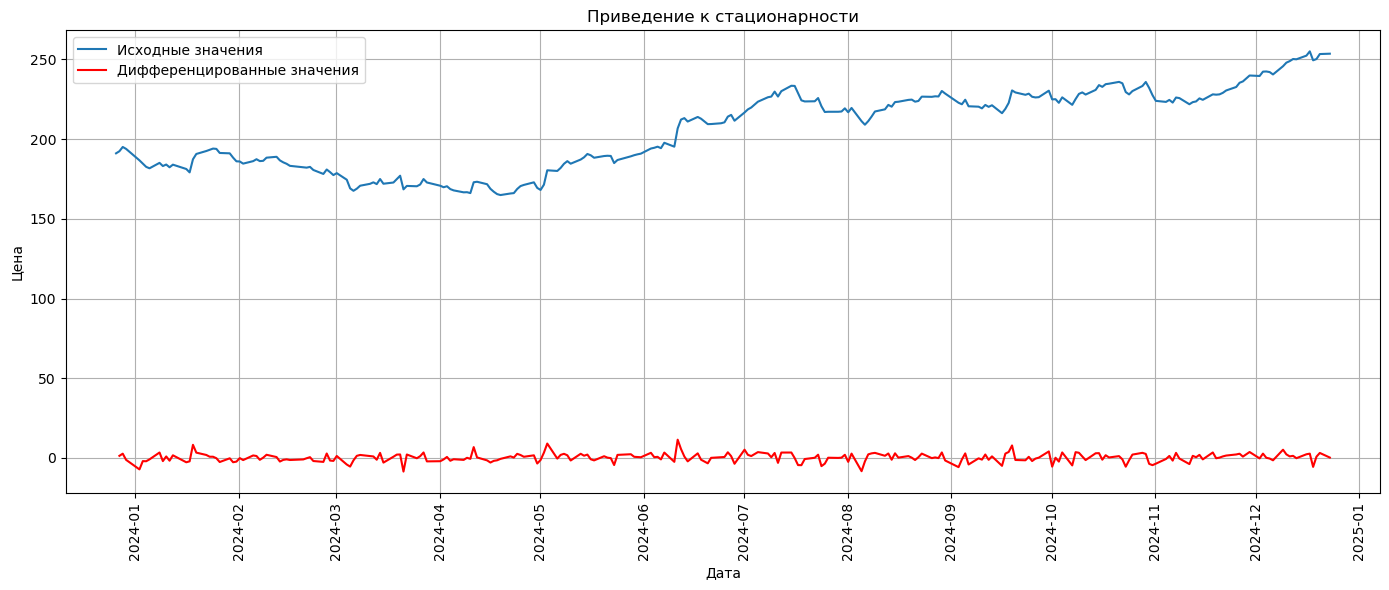

Результаты теста Дики-Фуллера:
ADF Statistic: -14.853978651376314
p-value: 1.7597601746217707e-27
Критические значения:
	1%: -3.4568881317725864
	5%: -2.8732185133016057
	10%: -2.5729936189738876


In [43]:
# Дифференцирование для стационарности
detrended_data = deseasonalized.diff().dropna()

# Визуализация данных
plt.figure(figsize=(14, 6))
plt.plot(deseasonalized.index, deseasonalized, label="Исходные значения")
plt.plot(detrended_data.index, detrended_data, color="red", label="Дифференцированные значения")
plt.gca().xaxis.set_major_locator(mdates.MonthLocator()) 
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().set_xlim(deseasonalized.index[0]-pd.Timedelta(days=15), deseasonalized.index[-1]+pd.Timedelta(days=15))
plt.xlabel("Дата")
plt.ylabel("Цена")
plt.title("Приведение к стационарности")
plt.gcf().autofmt_xdate()
plt.xticks(rotation=90, ha='center')
plt.tight_layout()
plt.grid()
plt.legend()
plt.show()

# Функция для проведения теста ADF
def adf_test(series):
    result = adfuller(series, autolag='AIC')
    print('Результаты теста Дики-Фуллера:')
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print('Критические значения:')
    for key, value in result[4].items():
        print(f'\t{key}: {value}')

# Применение теста ADF к детрендированным данным
adf_test(detrended_data)

### Построение и оценка моделей ARIMA

AR Модель

In [52]:
def evaluate_arima_model(X, arima_order):
    train_size = int(len(X) * 0.7)
    train, test = X[:train_size], X[train_size:]
    
    # Использование trend='ct' для включения константы и линейного тренда
    model = ARIMA(train, order=arima_order, trend='ct')
    model_fit = model.fit()
    
    forecast = model_fit.forecast(steps=len(test))
    
    mae = mean_absolute_error(test, forecast)
    rmse = np.sqrt(mean_squared_error(test, forecast))
    
    return mae, rmse

# Инициализация параметров
p_values = range(0, 10)
d_values = [0]  # Поскольку данные уже детрендированы, d остается 0
q_values = [0]

# Установка индекса для detrended_data
detrended_data.index = pd.date_range(start=detrended_data.index[0], periods=len(detrended_data), freq='D')

# Поиск лучшей модели AR
best_score_ar, best_cfg_ar = float("inf"), None
for p in p_values:
    for d in d_values:
        for q in q_values:
            order = (p, d, q)
            try:
                mae, rmse = evaluate_arima_model(detrended_data.values, order)
                if mae < best_score_ar:
                    best_score_ar, best_cfg_ar = mae, order
                print(f'AR{order} MAE={mae:.3f} RMSE={rmse:.3f}')
            except:
                continue

print(f'Лучшая модель AR{best_cfg_ar} MAE={best_score_ar:.3f}')

AR(0, 0, 0) MAE=2.052 RMSE=2.646
AR(1, 0, 0) MAE=2.047 RMSE=2.644
AR(2, 0, 0) MAE=2.047 RMSE=2.646
AR(3, 0, 0) MAE=2.046 RMSE=2.645
AR(4, 0, 0) MAE=2.040 RMSE=2.642
AR(5, 0, 0) MAE=2.041 RMSE=2.648
AR(6, 0, 0) MAE=2.039 RMSE=2.641
AR(7, 0, 0) MAE=2.040 RMSE=2.642
AR(8, 0, 0) MAE=2.041 RMSE=2.643
AR(9, 0, 0) MAE=2.039 RMSE=2.641
Лучшая модель AR(6, 0, 0) MAE=2.039


MA Модель

In [56]:
p_values = [0]
d_values = [0]
q_values = range(0, 10)

detrended_data.index = pd.date_range(start=detrended_data.index[0], periods=len(detrended_data), freq='D')

best_score_ma, best_cfg_ma = float("inf"), None
for p in p_values:
    for d in d_values:
        for q in q_values:
            order = (p, d, q)
            try:
                mae, rmse = evaluate_arima_model(detrended_data.values, order)
                if mae < best_score_ma:
                    best_score_ma, best_cfg_ma = mae, order
                print(f'MA{order} MAE={mae:.3f} RMSE={rmse:.3f}')
            except:
                continue

print(f'Лучшая модель MA{best_cfg_ma} MAE={best_score_ma:.3f}')

MA(0, 0, 0) MAE=2.052 RMSE=2.646
MA(0, 0, 1) MAE=2.047 RMSE=2.644
MA(0, 0, 2) MAE=2.048 RMSE=2.646
MA(0, 0, 3) MAE=2.045 RMSE=2.645
MA(0, 0, 4) MAE=2.036 RMSE=2.640
MA(0, 0, 5) MAE=2.037 RMSE=2.645
MA(0, 0, 6) MAE=2.038 RMSE=2.642
MA(0, 0, 7) MAE=2.040 RMSE=2.650
MA(0, 0, 8) MAE=2.040 RMSE=2.653
MA(0, 0, 9) MAE=2.042 RMSE=2.652
Лучшая модель MA(0, 0, 4) MAE=2.036


ARMA Модель

In [64]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="statsmodels")
p_values = range(0, 5)
d_values = [0]
q_values = range(0, 5)

detrended_data.index = pd.date_range(start=detrended_data.index[0], periods=len(detrended_data), freq='D')

best_score_arma, best_cfg_arma = float("inf"), None
for p in p_values:
    for d in d_values:
        for q in q_values:
            order = (p, d, q)
            try:
                mae, rmse = evaluate_arima_model(detrended_data.values, order)
                if mae < best_score_arma:
                    best_score_arma, best_cfg_arma = mae, order
                print(f'ARMA{order} MAE={mae:.3f} RMSE={rmse:.3f}')
            except:
                continue

print(f'Лучшая модель ARMA{best_cfg_arma} MAE={best_score_arma:.3f}')

ARMA(0, 0, 0) MAE=2.052 RMSE=2.646
ARMA(0, 0, 1) MAE=2.047 RMSE=2.644
ARMA(0, 0, 2) MAE=2.048 RMSE=2.646
ARMA(0, 0, 3) MAE=2.045 RMSE=2.645
ARMA(0, 0, 4) MAE=2.036 RMSE=2.640
ARMA(1, 0, 0) MAE=2.047 RMSE=2.644
ARMA(1, 0, 1) MAE=2.048 RMSE=2.644
ARMA(1, 0, 2) MAE=2.048 RMSE=2.646
ARMA(1, 0, 3) MAE=2.036 RMSE=2.639
ARMA(1, 0, 4) MAE=2.035 RMSE=2.639
ARMA(2, 0, 0) MAE=2.047 RMSE=2.646
ARMA(2, 0, 1) MAE=2.048 RMSE=2.646
ARMA(2, 0, 2) MAE=2.057 RMSE=2.680
ARMA(2, 0, 3) MAE=2.041 RMSE=2.649
ARMA(2, 0, 4) MAE=2.039 RMSE=2.644
ARMA(3, 0, 0) MAE=2.046 RMSE=2.645
ARMA(3, 0, 1) MAE=2.040 RMSE=2.638
ARMA(3, 0, 2) MAE=2.040 RMSE=2.647
ARMA(3, 0, 3) MAE=2.044 RMSE=2.651
ARMA(3, 0, 4) MAE=2.037 RMSE=2.642
ARMA(4, 0, 0) MAE=2.040 RMSE=2.642
ARMA(4, 0, 1) MAE=2.035 RMSE=2.637
ARMA(4, 0, 2) MAE=2.036 RMSE=2.638
ARMA(4, 0, 3) MAE=2.035 RMSE=2.640
ARMA(4, 0, 4) MAE=2.087 RMSE=2.704
Лучшая модель ARMA(4, 0, 3) MAE=2.035


ARIMA Модель

In [67]:
p_values = range(0, 3)
d_values = range(0, 3)
q_values = range(0, 3)

detrended_data.index = pd.date_range(start=detrended_data.index[0], periods=len(detrended_data), freq='D')

best_score_arima, best_cfg_arima = float("inf"), None
for p in p_values:
    for d in d_values:
        for q in q_values:
            order = (p, d, q)
            try:
                mae, rmse = evaluate_arima_model(detrended_data.values, order)
                if mae < best_score_arima:
                    best_score_arima, best_cfg_arima = mae, order
                print(f'ARIMA{order} MAE={mae:.3f} RMSE={rmse:.3f}')
            except:
                continue

print(f'Лучшая модель ARIMA{best_cfg_arima} MAE={best_score_arima:.3f}')

ARIMA(0, 0, 0) MAE=2.052 RMSE=2.646
ARIMA(0, 0, 1) MAE=2.047 RMSE=2.644
ARIMA(0, 0, 2) MAE=2.048 RMSE=2.646
ARIMA(1, 0, 0) MAE=2.047 RMSE=2.644
ARIMA(1, 0, 1) MAE=2.048 RMSE=2.644
ARIMA(1, 0, 2) MAE=2.048 RMSE=2.646
ARIMA(2, 0, 0) MAE=2.047 RMSE=2.646
ARIMA(2, 0, 1) MAE=2.048 RMSE=2.646
ARIMA(2, 0, 2) MAE=2.057 RMSE=2.680
Лучшая модель ARIMA(0, 0, 1) MAE=2.047


Прогноз для каждой модели

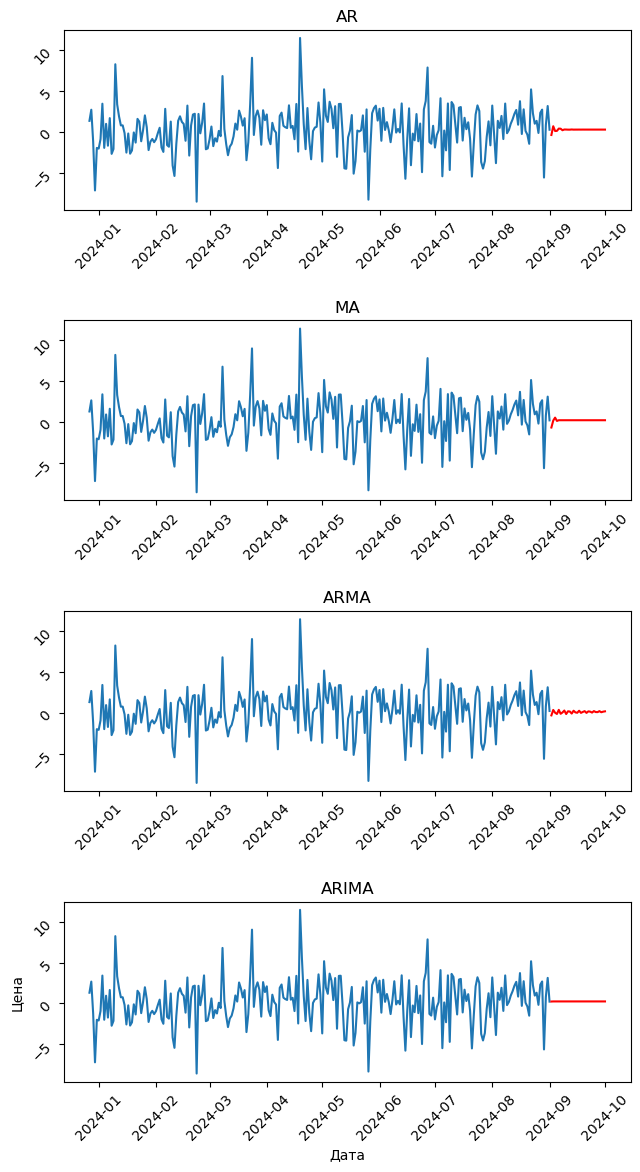

In [70]:
model_ar = ARIMA(detrended_data, order=best_cfg_ar)
model_ma = ARIMA(detrended_data, order=best_cfg_ma)
model_arma = ARIMA(detrended_data, order=best_cfg_arma)
model_arima = ARIMA(detrended_data, order=best_cfg_arima)

model_fit_ar = model_ar.fit()
model_fit_ma = model_ma.fit()
model_fit_arma = model_arma.fit()
model_fit_arima = model_arima.fit()
forecast_ar = model_fit_ar.forecast(steps=30)
forecast_ma = model_fit_ma.forecast(steps=30)
forecast_arma = model_fit_arma.forecast(steps=30)
forecast_arima = model_fit_arima.forecast(steps=30)

fig,ax = plt.subplots(4)
fig.tight_layout()
fig.set_figheight(12)
ax[0].plot(detrended_data.index, detrended_data, label='Исторические данные')
ax[1].plot(detrended_data.index, detrended_data, label='Исторические данные')
ax[2].plot(detrended_data.index, detrended_data, label='Исторические данные')
ax[3].plot(detrended_data.index, detrended_data, label='Исторические данные')
ax[0].plot(forecast_ar.index, forecast_ar, color='red', label='Прогноз')
ax[1].plot(forecast_ma.index, forecast_ma, color='red', label='Прогноз')
ax[2].plot(forecast_arma.index, forecast_arma, color='red', label='Прогноз')
ax[3].plot(forecast_arima.index, forecast_arima, color='red', label='Прогноз')
ax[0].title.set_text("AR")
ax[1].title.set_text("MA")
ax[2].title.set_text("ARMA")
ax[3].title.set_text("ARIMA")
plt.xlabel('Дата')
plt.ylabel('Цена')
ax[0].tick_params(labelrotation=45)
ax[1].tick_params(labelrotation=45)
ax[2].tick_params(labelrotation=45)
ax[3].tick_params(labelrotation=45)
plt.show()

In [72]:
test_data = detrended_data[-30:]

forecast_ar_values = forecast_ar.values
forecast_ma_values = forecast_ma.values
forecast_arma_values = forecast_arma.values
forecast_arima_values = forecast_arima.values

metrics = {
    "Model": ["AR", "MA", "ARMA", "ARIMA"],
    "MAE": [
        mean_absolute_error(test_data, forecast_ar_values),
        mean_absolute_error(test_data, forecast_ma_values),
        mean_absolute_error(test_data, forecast_arma_values),
        mean_absolute_error(test_data, forecast_arima_values),
    ],
    "RMSE": [
        np.sqrt(mean_squared_error(test_data, forecast_ar_values)),
        np.sqrt(mean_squared_error(test_data, forecast_ma_values)),
        np.sqrt(mean_squared_error(test_data, forecast_arma_values)),
        np.sqrt(mean_squared_error(test_data, forecast_arima_values)),
    ],
    "MAPE": [
        mean_absolute_percentage_error(test_data, forecast_ar_values),
        mean_absolute_percentage_error(test_data, forecast_ma_values),
        mean_absolute_percentage_error(test_data, forecast_arma_values),
        mean_absolute_percentage_error(test_data, forecast_arima_values),
    ],
}

metrics_df = pd.DataFrame(metrics)
print(metrics_df)

   Model       MAE      RMSE      MAPE
0     AR  1.662860  2.190489  1.007580
1     MA  1.661373  2.185835  1.003466
2   ARMA  1.755969  2.295258  0.997621
3  ARIMA  1.687598  2.229638  1.020439


На основе полученных метрик, можно сказать, что модель ARMA лучше всего предсказала курс Apple
